In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


# Index
* Importing Libraries
* Reading csv file
* Simplify the data
* analysis
* dropping unnecessary columns
* EDA
* Word cloud positive data
* Word cloud negative data
* TFIDF for sentiment analysis
* Train Test Split
* LogisticRegression
* Accuracy Score: 85%

# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Reading csv file

In [3]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv',delimiter=',', encoding='ISO-8859-1')

In [4]:
df.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048572 entries, 0 to 1048571
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   polarity of tweet   1048572 non-null  int64 
 1   id of the tweet     1048572 non-null  int64 
 2   date of the tweet   1048572 non-null  object
 3   query               1048572 non-null  object
 4   user                1048572 non-null  object
 5   text of the tweet   1048572 non-null  object
dtypes: int64(2), object(4)
memory usage: 48.0+ MB


In [6]:
df.isnull().sum()

polarity of tweet     0
id of the tweet       0
date of the tweet     0
query                 0
user                  0
text of the tweet     0
dtype: int64

# Simplify the data

In [7]:
df.columns=['sentiment','id','date','query','username','text']

In [8]:
df.head()

,sentiment,id,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [9]:
df.shape

(1048572, 6)

# Analysis

In [10]:
df['sentiment'].value_counts()

0    799996
4    248576
Name: sentiment, dtype: int64

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

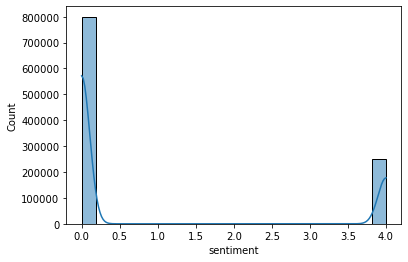

In [12]:
sns.histplot(df['sentiment'],kde=True)

<AxesSubplot:xlabel='sentiment', ylabel='count'>

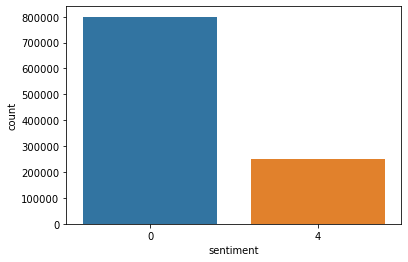

In [13]:
sns.countplot(df['sentiment'])

In [14]:
df['query'].value_counts()

NO_QUERY    1048572
Name: query, dtype: int64

# dropping unnecessary columns

In [15]:
df=df.drop(columns=['query'])

In [16]:
df.head()

,sentiment,id,date,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,joy_wolf,@Kwesidei not the whole crew


In [17]:
texts = df['text']

In [18]:
text_lens = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_lens)

# EDA

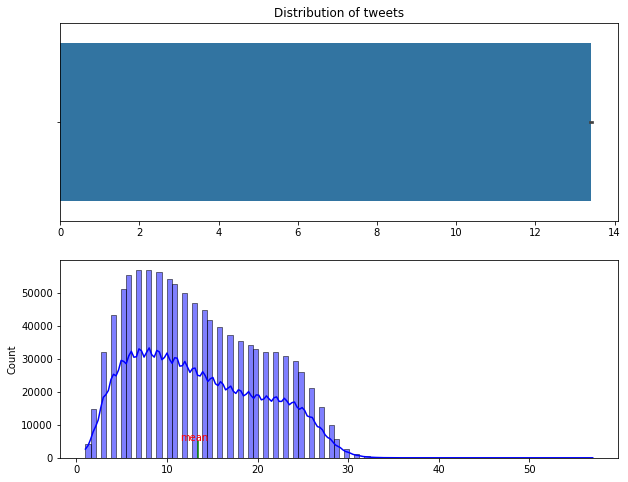

In [19]:
fig, axes = plt.subplots(2,1, figsize=(10, 8))
axes[0].set_title('Distribution of tweets')
sns.barplot(text_lens, ax=axes[0])
sns.histplot(text_lens,bins=100, kde=True, ax=axes[1],color='blue')
axes[1].vlines(len_mean, 0, 5000, color = 'g')
plt.annotate("mean", xy=(len_mean, 5000), xytext=(len_mean-2, 5050),color='r')
plt.show()

In [20]:
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()
corpus = df['text'].tolist()
print(len(corpus))
print(corpus[0])

1048572
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


In [21]:
final_corpus = []
final_corpus_joined = []
for i in df.index:
    text = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    text = text.lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    text = text.split()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text  if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

In [22]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["sentiment"] = df["sentiment"].values

In [23]:
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = df['sentiment'].values
data_eda.head()

,text,sentiment
0,"[upset, update, facebook, texting, might, cry,...",0
1,"[kenichan, dived, many, time, ball, managed, s...",0
2,"[whole, body, feel, itchy, like, fire]",0
3,"[nationwideclass, behaving, mad, see]",0
4,"[kwesidei, whole, crew]",0


In [24]:
positive = data_eda[data_eda['sentiment'] == 4]
positive_list = positive['text'].tolist()
negative = data_eda[data_eda['sentiment'] == 0]
negative_list = negative['text'].tolist()

In [25]:
positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])

# TFIDF for sentiment analysis

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
xt = tfidf.fit_transform(data_cleaned['text'])
y = data_cleaned['sentiment']

# Train Test Split

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xt, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify = y)

# LogisticRegression

In [30]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression

In [31]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

# Accuracy Score: 85% 

In [32]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
accuracy_score(y_train,y_train_pred)*100

85.67119735019779